<a href="https://colab.research.google.com/github/zjzsu2000/CMPE258/blob/master/assignment5/b)_Date_translation_using_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optional Graded assignment 5 




#  b)date translation using Attention

In [6]:
! pip install faker

     |████████████████████████████████| 1.0MB 2.7MB/s 


In [13]:
pip install np_utils

In [0]:
import random
import numpy as np
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM 
from keras.layers import Multiply,RepeatVector, Dense, Activation, Lambda
from faker import Faker
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

## 1 - Translating human readable dates into machine readable dates



### 1.1 - Dataset



In [0]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:01<00:00, 6631.04it/s]


In [0]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

In [0]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [0]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Target after preprocessing (one-hot): [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


## 2 - Neural machine translation with attention



### 2.1 - Attention mechanism


In [0]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

In [0]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor1(concat)
    e = densor2(e)
    alphas = activator(e)
    context = dotor([alphas, a])     
    return context

In [0]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [0]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
     
    outputs = []
    
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    for t in range(Ty):          
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        out = output_layer(s)
        outputs.append(out)
    model = Model(inputs = [X, s0, c0], outputs = outputs)

    return model

In [0]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [0]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 30, 64)        17920       input_1[0][0]                    
____________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_1[0][0]            

In [0]:
out = model.compile(optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01),
                    metrics=['accuracy'],
                    loss='categorical_crossentropy')
out

In [0]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [0]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1
10000/10000 [==============================] - 37s - loss: 17.6637 - dense_3_loss_1: 1.4564 - dense_3_loss_2: 1.1931 - dense_3_loss_3: 1.8566 - dense_3_loss_4: 2.7559 - dense_3_loss_5: 0.9145 - dense_3_loss_6: 1.3650 - dense_3_loss_7: 2.7363 - dense_3_loss_8: 1.0627 - dense_3_loss_9: 1.7362 - dense_3_loss_10: 2.5870 - dense_3_acc_1: 0.3589 - dense_3_acc_2: 0.5990 - dense_3_acc_3: 0.2796 - dense_3_acc_4: 0.0705 - dense_3_acc_5: 0.9524 - dense_3_acc_6: 0.2643 - dense_3_acc_7: 0.0386 - dense_3_acc_8: 0.9143 - dense_3_acc_9: 0.2431 - dense_3_acc_10: 0.1049    


In [0]:
model.load_weights('models/model.h5')

In [0]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-05-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


You can also change these examples to test with your own examples. The next part will give you a better sense on what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 

## 3 - Visualizing Attentio



### 3.1 - Getting the activations from the network


In [0]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 30, 64)        17920       input_1[0][0]                    
____________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_1[0][0]            

Trainable params: 52,960
Non-trainable params: 0
____________________________________________________________________________________________________


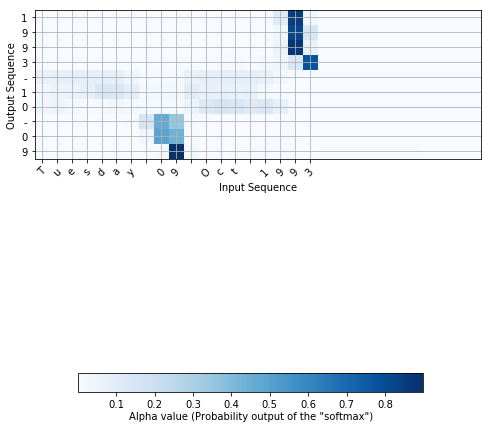

In [0]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)